# 机器学习练习-聚类
代码更新地址：https://github.com/fengdu78/WZU-machine-learning-course

代码修改并注释：黄海广，haiguang2000@wzu.edu.cn 

在本练习中，我们将实现K-means聚类，并使用它来压缩图像。 我们将从一个简单的2D数据集开始，以了解K-means是如何工作的，然后我们将其应用于图像压缩。 我们还将对主成分分析进行实验，并了解如何使用它来找到面部图像的低维表示。

## K-means 聚类

我们将实施和应用K-means到一个简单的二维数据集，以获得一些直观的工作原理。 K-means是一个迭代的，无监督的聚类算法，将类似的实例组合成簇。 该算法通过猜测每个簇的初始聚类中心开始，然后重复将实例分配给最近的簇，并重新计算该簇的聚类中心。 我们要实现的第一部分是找到数据中每个实例最接近的聚类中心的函数。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
def find_closest_centroids(X, centroids):
    # 获取样本数量m和聚类中心数量k
    m = X.shape[0]
    k = centroids.shape[0]
    # 初始化每个样本的聚类索引
    idx = np.zeros(m)
    # 遍历每个样本
    for i in range(m):
        # 初始化最小距离
        min_dist = 1000000
        # 遍历每个聚类中心
        for j in range(k):
            # 计算样本与聚类中心的距离
            dist = np.sum((X[i, :] - centroids[j, :])**2)
            # 如果距离小于最小距离，则更新最小距离和聚类索引
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    return idx

让我们来测试这个函数，以确保它的工作正常。 我们将使用练习中提供的测试用例。

In [3]:
data2 = pd.read_csv('data/ex7data2.csv')
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


In [4]:
X=data2.values

In [5]:
initial_centroids = initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

array([0., 2., 1.])

输出与文本中的预期值匹配（记住我们的数组是从零开始索引的，而不是从一开始索引的，所以值比练习中的值低一个）。 接下来，我们需要一个函数来计算簇的聚类中心。 聚类中心只是当前分配给簇的所有样本的平均值。

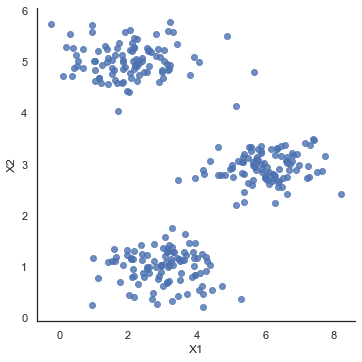

In [6]:
sb.set(context="notebook", style="white")
sb.lmplot(x='X1', y='X2', data=data2, fit_reg=False)
plt.show()

In [7]:
def compute_centroids(X, idx, k):
    # 获取样本数量m和特征数量n
    m, n = X.shape
    # 初始化聚类中心
    centroids = np.zeros((k, n))
    for i in range(k):
        # 找到属于第i个聚类的样本的索引
        indices = np.where(idx == i)
        # 计算该聚类的新聚类中心（取属于该聚类的样本的平均值）
        centroids[i, :] = (np.sum(X[indices, :], axis=1) /
                           len(indices[0])).ravel()
    return centroids

In [8]:
compute_centroids(data2.values, idx, 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

此输出也符合练习中的预期值。 
下一部分涉及实际运行该算法的一些迭代次数和可视化结果。 
这个步骤是由于并不复杂，我将从头开始构建它。 为了运行算法，我们只需要在将样本分配给最近的簇并重新计算簇的聚类中心。

In [9]:
def run_k_means(X, initial_centroids, max_iters):
    # 获取样本数量m和特征数量n
    m, n = X.shape
    # 获取聚类中心数量k
    k = initial_centroids.shape[0]
    # 初始化每个样本的聚类索引
    idx = np.zeros(m)
    # 初始化聚类中心
    centroids = initial_centroids

    for i in range(max_iters):
        # 找到每个样本点与最近的聚类中心的索引
        idx = find_closest_centroids(X, centroids)
        # 根据样本点的聚类索引重新计算聚类中心
        centroids = compute_centroids(X, idx, k)

    return idx, centroids

In [10]:
idx, centroids = run_k_means(X, initial_centroids, 10)

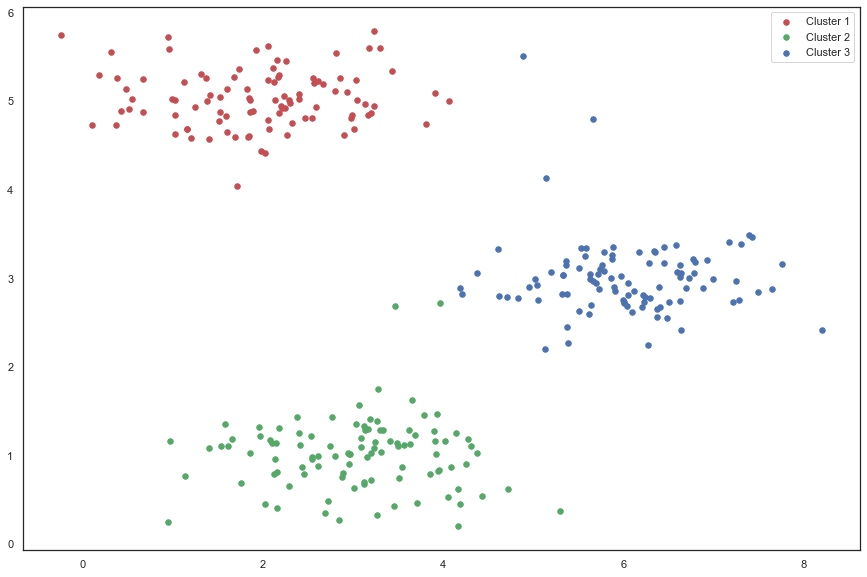

In [11]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()
plt.show()

我们跳过的一个步骤是初始化聚类中心的过程。 这可以影响算法的收敛。 我们的任务是创建一个选择随机样本并将其用作初始聚类中心的函数。

In [12]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)

    for i in range(k):
        centroids[i, :] = X[idx[i], :]

    return centroids

In [13]:
init_centroids(X, 3)

array([[1.52334113, 4.87916159],
       [3.06192918, 1.5719211 ],
       [1.75164337, 0.68853536]])

## k值的选择
使用“肘部法则”选取k值

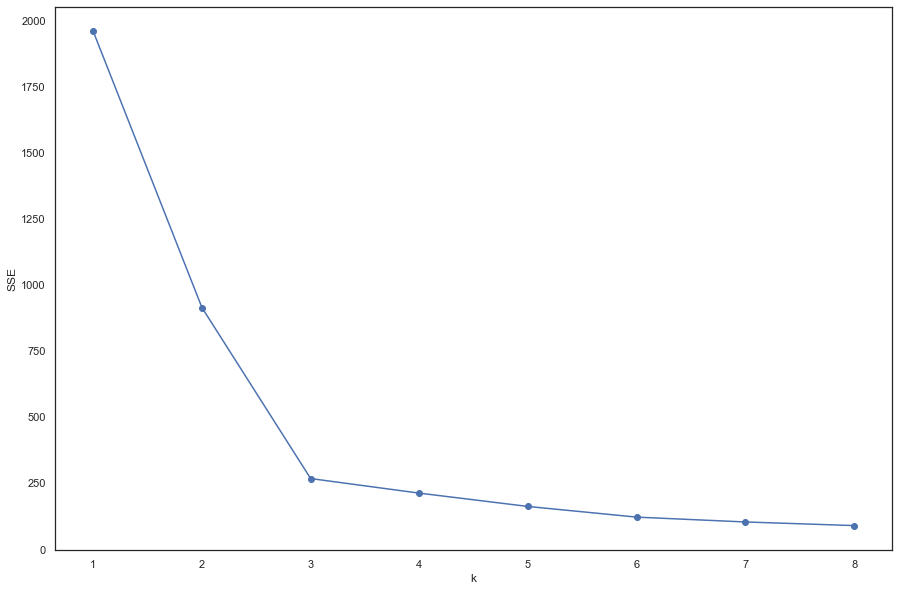

In [14]:
from sklearn.cluster import KMeans

# '利用SSE选择k'
SSE = []  # 存放每次结果的误差平方和
for k in range(1, 9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(data2)
    SSE.append(estimator.inertia_)
X = range(1, 9)

plt.figure(figsize=(15, 10))
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

图中可以看出，k=3的时候是肘点，所以，选择k=3.

## K-means图像压缩

我们的下一个任务是将K-means应用于图像压缩。 从下面的演示可以看到，我们可以使用聚类来找到最具代表性的少数颜色，并使用聚类分配将原始的24位颜色映射到较低维的颜色空间。 

下面是我们要压缩的图像。

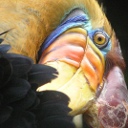

In [15]:
from IPython.display import Image
Image(filename='data/bird_small.png')

The raw pixel data has been pre-loaded for us so let's pull it in.

In [16]:
image_data = loadmat('data/bird_small.mat')
# image_data

In [17]:
A = image_data['A']
A.shape

(128, 128, 3)

现在我们需要对数据应用一些预处理，并将其提供给K-means算法。

In [18]:
# 归一化数值范围
A = A / 255.
# 重塑数组形状
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

In [19]:
# 随机初始化聚类中心
initial_centroids = init_centroids(X, 16)
# 运行K-means算法
idx, centroids = run_k_means(X, initial_centroids, 10)
# 最后一次获取最近的聚类中心
idx = find_closest_centroids(X, centroids)
# 将每个像素映射到聚类中心的值
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [20]:
# 重塑原始维度
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

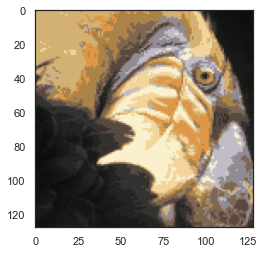

In [21]:
plt.imshow(X_recovered)
plt.show()

您可以看到我们对图像进行了压缩，但图像的主要特征仍然存在。 这就是K-means。 下面我们来用scikit-learn来实现K-means。

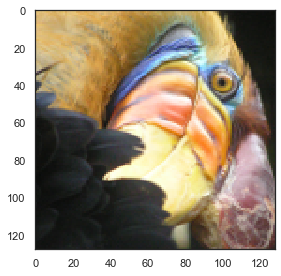

In [22]:
from skimage import io

# 将图像转换为浮点数，否则聚类后的颜色会变得奇怪
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)
plt.show()

In [23]:
pic.shape

(128, 128, 3)

In [24]:
# serialize data
data = pic.reshape(128*128, 3)

In [25]:
data.shape

(16384, 3)

In [26]:
from sklearn.cluster import KMeans#导入kmeans库

model = KMeans(n_clusters=16, n_init=100)

In [27]:
model.fit(data)

KMeans(n_clusters=16, n_init=100)

In [28]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [29]:
centroids[C].shape

(16384, 3)

In [30]:
compressed_pic = centroids[C].reshape((128,128,3))

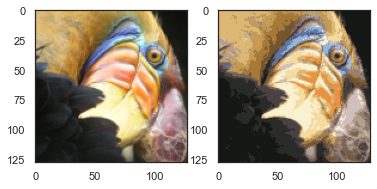

In [31]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## 密度聚类

DBSCAN(Density-Based Spatial Clustering of Applications with Noise)是一个比较有代表性的基于密度的聚类算法。与划分和层次聚类方法不同，它将簇定义为密度相连的点的最大集合，能够把具有足够高密度的区域划分为簇，并可在噪声的空间数据库中发现任意形状的聚类。

In [32]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [33]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

创建样本数据

In [34]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

标准化数据

In [35]:
X = StandardScaler().fit_transform(X)

在DBSCAN使用两个超参数：

扫描半径 (eps)和最小包含点数(minPts)来获得簇的数量，而不是猜测簇的数目。
- (1)扫描半径 (eps) : 
用于定位点/检查任何点附近密度的距离度量，即扫描半径。
- (2)最小包含点数(minPts) ：
聚集在一起的最小点数(阈值)，该区域被认为是稠密的。

我们定义一个`plot_dbscan(MyEps, MiniSample)`函数，`MyEps`代表`eps`，`MiniSample`代表`minPts`。

In [36]:
def plot_dbscan(MyEps, MiniSample):
    db = DBSCAN(eps=MyEps, min_samples=MiniSample).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # 标签中的簇数，忽略噪声点（如果存在）。
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("估计的簇的数量: %d" % n_clusters_)
    print("估计的噪声点数量: %d" % n_noise_)
    print("同一性(Homogeneity): %0.4f" %
          metrics.homogeneity_score(labels_true, labels))
    print("完整性(Completeness): %0.4f" %
          metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("ARI(Adjusted Rand Index): %0.4f" %
          metrics.adjusted_rand_score(labels_true, labels))
    print("AMI(Adjusted Mutual Information): %0.4f" %
          metrics.adjusted_mutual_info_score(labels_true, labels))
    print("轮廓系数(Silhouette Coefficient): %0.4f" %
          metrics.silhouette_score(X, labels))

    # #############################################################################
    # 画出结果

    # 黑色点代表噪声点
    unique_labels = set(labels)
    colors = [
        plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
    ]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 1, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title("簇的数量为: %d" % n_clusters_, fontsize=18)

#     plt.savefig(str(MyEps) + str(MiniSample) + '.png')#保存图片
    plt.show()

估计的簇的数量: 3
估计的噪声点数量: 18
同一性(Homogeneity): 0.9530
完整性(Completeness): 0.8832
V-measure: 0.917
ARI(Adjusted Rand Index): 0.9517
AMI(Adjusted Mutual Information): 0.9165
轮廓系数(Silhouette Coefficient): 0.6255


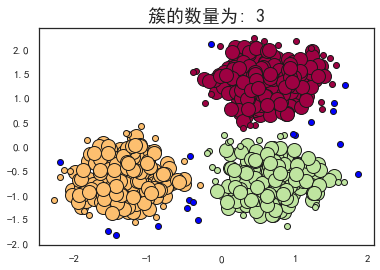

In [37]:
plot_dbscan(0.3, 10)

估计的簇的数量: 12
估计的噪声点数量: 516
同一性(Homogeneity): 0.3128
完整性(Completeness): 0.2489
V-measure: 0.277
ARI(Adjusted Rand Index): 0.0237
AMI(Adjusted Mutual Information): 0.2673
轮廓系数(Silhouette Coefficient): -0.3659


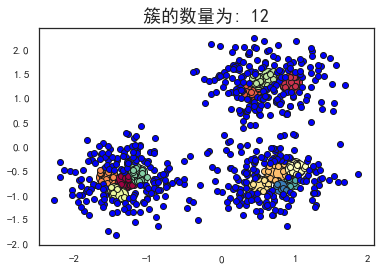

In [38]:
plot_dbscan(0.1, 10)

估计的簇的数量: 1
估计的噪声点数量: 2
同一性(Homogeneity): 0.0010
完整性(Completeness): 0.0586
V-measure: 0.002
ARI(Adjusted Rand Index): -0.0000
AMI(Adjusted Mutual Information): -0.0011
轮廓系数(Silhouette Coefficient): 0.0611


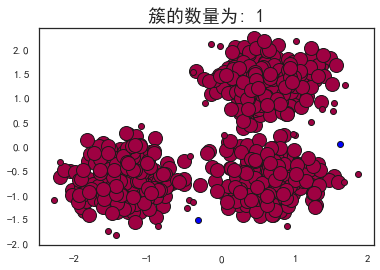

In [39]:
plot_dbscan(0.4, 10)

估计的簇的数量: 2
估计的噪声点数量: 13
同一性(Homogeneity): 0.5365
完整性(Completeness): 0.8263
V-measure: 0.651
ARI(Adjusted Rand Index): 0.5414
AMI(Adjusted Mutual Information): 0.6495
轮廓系数(Silhouette Coefficient): 0.3845


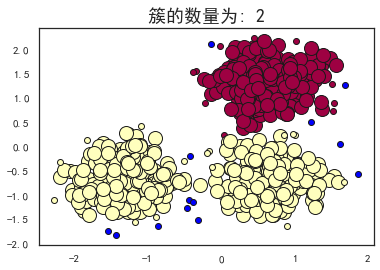

In [40]:
plot_dbscan(0.3, 6)

可以看到，当扫描半径 (eps)为0.3，同时最小包含点数(minPts)为10的时候，评价指标最高。

## 层次聚类

In [41]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

In [42]:
def plot_dendrogram(model, **kwargs):
    # 创建链接矩阵，然后绘制树状图

    # 创建每个节点下的样本计数
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # 绘制相应的树状图
    dendrogram(linkage_matrix, **kwargs)

In [43]:
iris = load_iris()
X = iris.data

In [44]:
# 设置距离阈值=0可确保计算完整的树。
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)

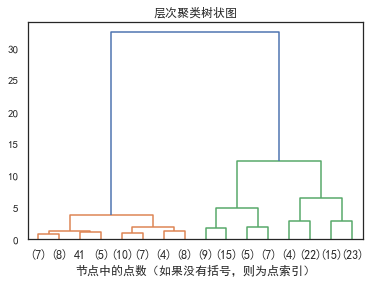

In [45]:
plt.title("层次聚类树状图")
# 绘制树状图的前三级
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("节点中的点数（如果没有括号，则为点索引）")
plt.show()

## 参考
- Andrew Ng. Machine Learning[EB/OL]. StanfordUniversity,2014.https://www.coursera.org/course/ml
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- https://scikit-learn.org/stable/auto_examples/cluster